# 3. Models
This notebook contains the Network Architectures and Data Evaluation Systems for the BA Thesis. The data from the dataset is already processed in the notebook `PreProcessing.ipnb` and saved to `data/processed/chords.json`. Also, some Statistics can be found there. If there is any concern how the data has been processed, look into the notebook - all is done there. It also uses functions from `functions/utils.py`, such that the code is more readable and not cluttured. 

**Brief Overview Of this Notebook:**

1. **Data Preparation**: Load the data from `chords.json`, add start/end tokens, padd them, split it into training and validation sets, and create data loaders.
2. **Model Building (GRU)**: Define the GRU-based RNN architecture.
3. **Model Building (LSTM)**: Define the LSTM-based RNN architecture.
4. **Results**: Look at generated Data and Discuss it.

## 1. Data Preparation
### 1.1 Load Chords from Dataset
Load chords from file `chords.data` in a json like format.

In [25]:
# all imports 
import torch.nn as nn
import json
import torch
import random
import numpy as np
from collections import Counter
from tqdm import tqdm
from scipy.spatial import distance
from scipy.spatial.distance import jensenshannon
from torch.utils.data import DataLoader, Dataset, random_split
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.nn.functional as F
import pretty_midi
from functions.utils import add_start_end_tokens
import matplotlib.pyplot as plt
import matplotlib

In [26]:
def load_chords(file_path):
    """
    Loads chords from a file and returns them as a 2D list.
    """
    with open(file_path, "r") as file:
        # Read the entire file as a string
        data_str = file.read()
        
        # Convert the string representation of lists into actual lists using json.loads
        chords_2d_list = json.loads(data_str)
        
    return chords_2d_list

all_chords = load_chords("data/processed/chords.json")

# add start and end tokens to data
all_chords = add_start_end_tokens(all_chords)
print(all_chords[0])  # Displaying the first chord sequence for verification

['<BOS>', 'A:hdim7', 'A:hdim7', 'D:7', 'D:7', 'G:min7', 'G:min7', 'C:7', 'C:7', 'B:maj7', 'B:maj7', 'C:hdim7', 'F:7', 'B-:maj7', 'B-:maj7', 'B-:maj7', 'B-:maj7', 'B:min7', 'B:min7', 'E:7', 'E:7', 'A:maj7', 'A:maj7', 'F#:min7', 'F#:min7', 'E-:hdim7', 'E-:hdim7', 'A-:7', 'A-:7', 'D-:maj7', 'D-:maj7', 'D-:maj7', 'D-:maj7', 'C:7', 'C:7', 'B:7', 'B:7', 'B-:maj7', 'B-:maj7', 'B-:maj7', 'B-:maj7', '<EOS>']


### 1.2 Examine the Data
Getting used to the data we are working with.

In [27]:
from functions.utils import encode_chords

chord_vocab, chord_to_idx, idx_to_chord, padded_sequences, vocab_size = encode_chords(all_chords)

print("Shape of sequnces(elements, lenght):", padded_sequences.shape)
print("Vocab size (all occuring chords + 2 tokens): ", vocab_size)
print("Chord vocab:------\n", chord_vocab, "\n--------------------")

print("Index of BOS:", chord_to_idx['<BOS>'])
print("Index of EOS:", chord_to_idx['<EOS>'])
print(chord_to_idx)
print("----------------")
print(idx_to_chord)

Shape of sequnces(elements, lenght): torch.Size([934, 522])
Vocab size (all occuring chords + 2 tokens):  118
Chord vocab:------
 ['<BOS>', '<EOS>', 'A#:dim7', 'A#:hdim7', 'A#:min7', 'A-:7', 'A-:dim7', 'A-:hdim7', 'A-:maj', 'A-:maj7', 'A-:min', 'A-:min7', 'A:7', 'A:dim7', 'A:hdim7', 'A:maj', 'A:maj7', 'A:min', 'A:min7', 'B-:7', 'B-:dim7', 'B-:hdim7', 'B-:maj', 'B-:maj7', 'B-:min', 'B-:min7', 'B:7', 'B:dim7', 'B:hdim7', 'B:maj', 'B:maj7', 'B:min', 'B:min7', 'C#:7', 'C#:dim7', 'C#:hdim7', 'C#:maj', 'C#:maj7', 'C#:min', 'C#:min7', 'C-:7', 'C-:maj', 'C:7', 'C:dim7', 'C:hdim7', 'C:maj', 'C:maj7', 'C:min', 'C:min7', 'D#:7', 'D#:dim7', 'D#:hdim7', 'D#:maj', 'D#:maj7', 'D#:min', 'D#:min7', 'D-:7', 'D-:dim7', 'D-:maj', 'D-:maj7', 'D-:min', 'D-:min7', 'D:7', 'D:dim7', 'D:hdim7', 'D:maj', 'D:maj7', 'D:min', 'D:min7', 'E-:7', 'E-:dim7', 'E-:hdim7', 'E-:maj', 'E-:maj7', 'E-:min', 'E-:min7', 'E:7', 'E:dim7', 'E:hdim7', 'E:maj', 'E:maj7', 'E:min', 'E:min7', 'F#:7', 'F#:dim7', 'F#:hdim7', 'F#:maj', 'F

### 1.3 Split Train and Validation
Before proceeding with the model, we split our dataset into a training set and a validation set. This will help us evaluate our model's performance on unseen data. This will be archived with pytorch dataloaders. We'll convert our dataset to PyTorch tensors and then create data loaders for training and validation sets.

In [28]:
# Define a custom dataset
class ChordDataset(Dataset):
    def __init__(self, padded_sequences):
        self.data = padded_sequences

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sequence = self.data[idx]
        
        # Compute the original length of the sequence (without padding) for pack sequence
        length = (sequence != 0).sum().item()  # Count non-zero tokens
        
        # Using the current token to predict the next token
        # So, we return (sequence[:-1], sequence[1:], length - 1)
        # We subtract 1 from the length because we're returning sequence[:-1] which has one token less
        return sequence[:-1], sequence[1:], length - 1

# Create dataset
dataset = ChordDataset(padded_sequences)

# Split the dataset into training and validation sets (80% train, 20% validation)
train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

## 3. Model Architecture (LSTM)
Lets now try the same thing with a LSTM. We will also measure the scores on the same validation set which comes in handy. Since measuring the performance is hard, we have now a way of quantifing the results better.

### 3.1 Set up LSTM
We will use an embedding layer to represent the integer-encoded chords as dense vectors, followed by an LSTM layer, and then a fully connected layer to produce the predictions for the next chord in the sequence.

Our LSTM model consists of the following layers:

- Embedding Layer: This converts our integer-encoded chords into dense vectors of fixed size. The embedding layer is beneficial as it allows the model to learn meaningful representations of the chords during training.
- LSTM Layer: This layer contains the LSTM cells. We also have n_layers = 2, meaning our LSTM has 2 stacked layers.
- Fully Connected Layer: The output from the LSTM layer is passed through a fully connected layer to produce predictions for the next chord in the sequence. The output size is vocab_size which is the size of our vocabulary (including padding and start end tokens
  ).

In [38]:
# Hyperparameters v2
num_epochs = 100
embedding_dim = 24#12
hidden_dim = 64#24
output_dim = vocab_size
n_layers = 4#2

In [30]:
class ChordLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout=0.5):
        super(ChordLSTM, self).__init__()
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # GRU layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, dropout=dropout, batch_first=True)
        
        # Linear layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x, lengths, hidden=None):
        # x: (batch_size, sequence_length)
        embedded = self.embedding(x)  # (batch_size, sequence_length, embedding_dim)
        
        # Pack the embedded sequences
        packed_embedded = pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)
        
        # GRU output
        packed_output, hidden = self.lstm(packed_embedded, hidden)
        
        # Unpack the output
        output, output_lengths = pad_packed_sequence(packed_output, batch_first=True, total_length=x.size(1)) 
        
        # Linear layer
        output = self.fc(output)  # (batch_size, sequence_length, output_dim)
        
        return output, hidden

# Initialize the model
model = ChordLSTM(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout=0.2)
model

ChordLSTM(
  (embedding): Embedding(118, 24)
  (lstm): LSTM(24, 64, num_layers=4, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=118, bias=True)
)

### 2.2 Train function
This one will be used for both models. Cross entrophy will be used and the optimizer will be adam.

In [39]:
# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Loss and optim --------------------------------------------------------------ASK HEREEE
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# for attention mechanism
default_value = 0.3
repetition_token = 0.8

# Modified training function
def train_model(model, train_loader, val_loader, epochs, optimizer, criterion, default_value=0, repetition_token=1):
    train_losses = []
    val_losses = []

    # Training loop
    for epoch in range(epochs):
        # Placeholder for accumulating batch losses
        batch_train_losses = []
        
        # Training
        model.train()
        for (input_seq, target_seq, lengths) in train_loader:
            input_seq, target_seq, lengths = input_seq.to(device), target_seq.to(device), lengths.to("cpu")
            optimizer.zero_grad()

            output, _ = model(input_seq, lengths)

            # Reshape output and target_seq for loss computation
            output_dim = output.shape[-1]
            output = output.contiguous().view(-1, output_dim)
            target_seq = target_seq.contiguous().view(-1)
            loss = criterion(output, target_seq)

            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())

        # Calculate average training loss for the epoch
        epoch_train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(epoch_train_loss)

        batch_val_losses = []

        # Validation
        model.eval()
        with torch.no_grad():
            for (input_seq, target_seq, lengths) in val_loader:
                input_seq, target_seq, lengths = input_seq.to(device), target_seq.to(device), lengths.to("cpu")

                output, _ = model(input_seq, lengths)

                # Reshape output and target_seq for loss computation
                output_dim = output.shape[-1]
                output = output.contiguous().view(-1, output_dim)
                target_seq = target_seq.contiguous().view(-1)

                val_loss = criterion(output, target_seq)
                batch_val_losses.append(val_loss.item())

            # Calculate average validation loss for the epoch
            epoch_val_loss = sum(batch_val_losses) / len(batch_val_losses)
            val_losses.append(epoch_val_loss)

        # Print average training and validation loss for the epoch
        if epoch % 1 == 0:
            print(f"Epoch {epoch+1}/{epochs}: Train Loss: {epoch_train_loss:.4f} | Validation Loss: {epoch_val_loss:.4f}")

    return train_losses, val_losses


# Train the GRU model
train_losses_lstm, val_losses_lstm = train_model(model, train_loader, val_loader, num_epochs, optimizer, criterion)

Epoch 1/100: Train Loss: 0.9491 | Validation Loss: 1.3038
Epoch 2/100: Train Loss: 0.9420 | Validation Loss: 1.3026
Epoch 3/100: Train Loss: 0.9291 | Validation Loss: 1.2937
Epoch 4/100: Train Loss: 0.9141 | Validation Loss: 1.2936
Epoch 5/100: Train Loss: 0.9058 | Validation Loss: 1.2931
Epoch 6/100: Train Loss: 0.9155 | Validation Loss: 1.3056
Epoch 7/100: Train Loss: 0.9104 | Validation Loss: 1.3076
Epoch 8/100: Train Loss: 0.9181 | Validation Loss: 1.2869
Epoch 9/100: Train Loss: 0.9174 | Validation Loss: 1.2945
Epoch 10/100: Train Loss: 0.9129 | Validation Loss: 1.2886
Epoch 11/100: Train Loss: 0.9108 | Validation Loss: 1.2907
Epoch 12/100: Train Loss: 0.9232 | Validation Loss: 1.3166
Epoch 13/100: Train Loss: 0.9291 | Validation Loss: 1.2993
Epoch 14/100: Train Loss: 0.9145 | Validation Loss: 1.2854
Epoch 15/100: Train Loss: 0.9074 | Validation Loss: 1.2899
Epoch 16/100: Train Loss: 0.9045 | Validation Loss: 1.2904
Epoch 17/100: Train Loss: 0.9217 | Validation Loss: 1.2946
Epoch 

### 2.3 Evaluate
Evaluate on the whole evaluation set.

In [42]:
def evaluate(model, iterator, criterion, device):
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for (input_seq, target_seq, lenghts) in iterator:
            input_seq, target_seq, lenghts = input_seq.to(device), target_seq.to(device), lenghts.to("cpu")

            output, _ = model(input_seq, lenghts)
            
            output_dim = output.shape[-1]
            output = output.contiguous().view(-1, output_dim)
            target_seq = target_seq.contiguous().view(-1)
            
            loss = criterion(output, target_seq)
            
            total_loss += loss.item()

    return total_loss / len(iterator)

val_loss = evaluate(model, val_loader, criterion, device)
print("Evaluation Loss (LSTM) on whole validation set: ", val_loss)

Evaluation Loss (LSTM) on whole validation set:  1.3434069395065307


### 2.5 Generate new Sequnces
After training our model, we will now use it and generate new sequnces.

**Multinomial sampling**:

torch.multinomial() function samples values from a multinomial distribution. The function takes in a tensor of probabilities (probs) and an integer which indicates how many samples to draw. In the case of torch.multinomial(probs, 1), it's drawing one sample based on our probabilities.

A intuitive way of understanding it:
- Imagine you have a weighted dice, where each face of the dice has a different probability of landing face up.
- If you  roll this dice, the face that lands up is sampled based on the weights (or probabilities) associated with each face.
- torch.multinomial() is doing a similar thing: given a set of probabilities (weights), it's "rolling the dice" and returning which "face" (index) was chosen.

This introduces randomness because, like rolling a weighted dice, you're not guaranteed to get the same outcome every time, even though some outcomes are more probable than others.

In [48]:
def generate_sequence(model, start_token, max_length, device, argmax:bool=False):
    model.eval()
    
    generated_sequence = [start_token]
    input_seq = torch.LongTensor([start_token]).unsqueeze(0).to(device)
    length = torch.tensor([1]).to("cpu")  # initial length is 1
    
    with torch.no_grad():
        for _ in range(max_length):

            # Pass input sequence and attention scores to the model
            output, _ = model(input_seq, length)
            
            # Take the last token's probabilities
            probabilities = nn.functional.softmax(output[0][-1], dim=0)
            
            # Sample a token from the distribution
            next_token = torch.multinomial(probabilities, 1).item()
            
            # or use argmax
            if argmax:
                probabilities = nn.functional.softmax(output[0][-1], dim=0)
                next_token = torch.argmax(probabilities).item()

            if next_token == 2:  # Check for <EOS>
                break
            
            generated_sequence.append(next_token)
            input_seq = torch.LongTensor(generated_sequence).unsqueeze(0).to(device)
            length = torch.tensor([len(generated_sequence)]).to("cpu")  # update the length
    
    return generated_sequence



def map_sequence(sequnce, ignore_tokens:bool=True):
    str_sequnce = []
    for s in sequnce:
        str_sequnce.append(idx_to_chord[s])

    if ignore_tokens:
        return str_sequnce[1:-1]
    else:
        return str_sequnce

print(map_sequence(generate_sequence(model, 1, 1000, device, argmax=False)))

LSTM_chords_generated = []
for _ in tqdm(range(500)):
    LSTM_chords_generated.append(map_sequence(generate_sequence(model, 1, 1000, device, argmax=False)))
    pass

['G:hdim7', 'G:hdim7', 'C:7', 'C:7', 'F:min7', 'F:min7', 'F:min7', 'F:min7', 'B:7', 'B:7', 'B:7', 'B:7', 'E:maj7', 'E:maj7', 'E:maj7', 'E:maj7', 'B-:7', 'B-:7', 'B-:7', 'B-:7', 'B-:min7', 'B-:min7', 'B-:min7', 'B-:min7', 'E-:maj', 'E-:maj', 'E-:maj', 'E-:maj', 'B:maj', 'E:dim7', 'E-:min7', 'E-:min7', 'B:7', 'E:dim7', 'C:min7', 'C:min7', 'B-:min7', 'B-:min7', 'E-:min7', 'E-:min7', 'A-:7', 'A-:7', 'B-:7', 'B-:7', 'B-:7', 'B-:7', 'B-:min7', 'B-:min7', 'E-:min7', 'A-:7', 'D-:7', 'D-:7', 'C:7', 'C:7', 'F:7', 'F:7', 'F:min7', 'F:min7', 'B-:7', 'B-:7', 'G:min7', 'G:min7', 'C:7', 'C:7', 'F:min7', 'F:min7', 'B-:7', 'B-:7', 'E-:maj7', 'E-:maj7', 'E-:maj7', 'E-:maj7', 'E-:maj7', 'E-:maj7', 'E-:maj7', 'E-:maj7', 'B-:min7', 'B-:min7', 'E-:7', 'E-:7', 'A-:maj', 'A-:maj', 'A-:maj', 'A-:maj', 'D:hdim7', 'D:hdim7', 'G:7']


 13%|█████▌                                    | 66/500 [00:26<02:54,  2.49it/s]


KeyboardInterrupt: 

In [44]:
def transform_notation(sequence):
    repeats = {4: '1', 3: '2.', 2: '2', 1: '4'}
    
    # Initialize an empty list for results
    results = []
    
    # Start iterating through the sequence
    i = 0
    while i < len(sequence):
        count = 1  # At least one occurrence of the chord
        chord = sequence[i]
        
        # Count consecutive repeats
        while i + count < len(sequence) and sequence[i + count] == chord:
            count += 1
        
        # Handle the special case where count is 5
        if count == 5:
            results.append(f"1{chord}")
            results.append(f"4{chord}")
            i += 5
            continue
        
        # Check for the chord spanning over a new measure
        measure_position = i % 4
        if measure_position + count > 4:
            # Number of beats the chord is played in the current measure
            beats_in_current_measure = 4 - measure_position
            # Number of beats the chord is played in the next measure
            beats_in_next_measure = count - beats_in_current_measure
            
            results.append(f"{repeats[beats_in_current_measure]}{chord}")
            results.append(f"{repeats[beats_in_next_measure]}{chord}")
            i += count
            continue
        
        # Add the transformed chord to the results for other cases
        results.append(f"{repeats[count]}{chord}")
        
        # Move to the next different chord
        i += count
    
    return results


# Test the function
test_sequence1 = ['A:min', 'A:min', 'A:min', 'A:min', 'A:min']
test_sequence2 = ['A:min', 'A:min', 'A:min', 'B:min']
test_sequence3 = ['A:min', 'B:min', 'C:min', 'D:min']
test_sequence4 = ['A:min', 'A:min', 'B:min', 'B:min', 'B:min', 'B:min']
test_sequence5 = ['A:min', 'A:min', 'B:min', 'B:min', 'B:min', 'B:min', 'C:min', 'C:min',  'C:min',  'C:min',  'C:min',  'C:min',  'C:min']
test_cases = [
    test_sequence1,
    test_sequence2,
    test_sequence3,
    test_sequence4,
    test_sequence5
]

In [45]:
def merge_chords(chords):
    grid = ['4', '2', '2.', '1']
    repeats = {'1': 4, '2': 2, '4': 1, '2.': 3}

    merged = []
    i = 0
    while i < len(chords):
        measure_fill = 0  # Counter to track current measure's fill level
        chord_sequence = []

        # Fill up the measure with chords
        while i < len(chords) and measure_fill < 4:
            chord = chords[i]
            chord_sequence.append(chord)
            measure_fill += 1
            i += 1
        
        # Process the chord sequence to merge similar adjacent chords
        j = 0
        while j < len(chord_sequence):
            count = chord_sequence[j:].count(chord_sequence[j])
            duration = max([k for k, v in repeats.items() if v <= count], key=repeats.get, default='4')
            merged.append(duration + chord_sequence[j])
            j += repeats[duration]

    return merged




# test function 
test = True

if test:
    # Test the function with the provided examples
    merged_chords = [merge_chords(tc) for tc in test_cases]

    additional_test_cases = [
        # Continuous repeating chords spanning multiple measures
        ['A:min', 'A:min', 'A:min', 'A:min', 'A:min', 'A:min', 'A:min', 'A:min', 'A:min'],
        
        # Mix of different chords with various lengths
        ['A:min', 'A:min', 'A:min', 'B:min', 'B:min', 'C:maj', 'C:maj', 'C:maj', 'C:maj', 'D:maj'],
        
        # Single chords
        ['A:min'],
        ['A:min', 'A:min'],
        ['A:min', 'A:min', 'A:min'],
        
        # Chords with half-measure durations
        ['A:min', 'A:min', 'B:min', 'B:min', 'C:maj', 'C:maj', 'D:maj', 'D:maj'],
        
        # Chords that don't fit exactly into the provided durations
        ['A:min', 'A:min', 'A:min', 'A:min', 'A:min', 'A:min', 'A:min'],
        
        # Mix of different chords with only one occurrence each
        ['A:min', 'B:min', 'C:maj', 'D:maj', 'E:maj', 'F:maj']
    ]
    
    merged_additional_chords = [merge_chords(tc) for tc in additional_test_cases]
    for inp, result in zip(test_cases + additional_test_cases, merged_chords + merged_additional_chords):
        print(inp)
        print(result)
        #print("\n")

['A:min', 'A:min', 'A:min', 'A:min', 'A:min']
['1A:min', '4A:min']
['A:min', 'A:min', 'A:min', 'B:min']
['2.A:min', '4B:min']
['A:min', 'B:min', 'C:min', 'D:min']
['4A:min', '4B:min', '4C:min', '4D:min']
['A:min', 'A:min', 'B:min', 'B:min', 'B:min', 'B:min']
['2A:min', '2B:min', '2B:min']
['A:min', 'A:min', 'B:min', 'B:min', 'B:min', 'B:min', 'C:min', 'C:min', 'C:min', 'C:min', 'C:min', 'C:min', 'C:min']
['2A:min', '2B:min', '2B:min', '2C:min', '1C:min', '4C:min']
['A:min', 'A:min', 'A:min', 'A:min', 'A:min', 'A:min', 'A:min', 'A:min', 'A:min']
['1A:min', '1A:min', '4A:min']
['A:min', 'A:min', 'A:min', 'B:min', 'B:min', 'C:maj', 'C:maj', 'C:maj', 'C:maj', 'D:maj']
['2.A:min', '4B:min', '4B:min', '2.C:maj', '4C:maj', '4D:maj']
['A:min']
['4A:min']
['A:min', 'A:min']
['2A:min']
['A:min', 'A:min', 'A:min']
['2.A:min']
['A:min', 'A:min', 'B:min', 'B:min', 'C:maj', 'C:maj', 'D:maj', 'D:maj']
['2A:min', '2B:min', '2C:maj', '2D:maj']
['A:min', 'A:min', 'A:min', 'A:min', 'A:min', 'A:min', 'A:m

## 4. Results

### 4.1 Compare losses 
Lets compare the losses of each network over the epochs. We wil also consider the validation losses.

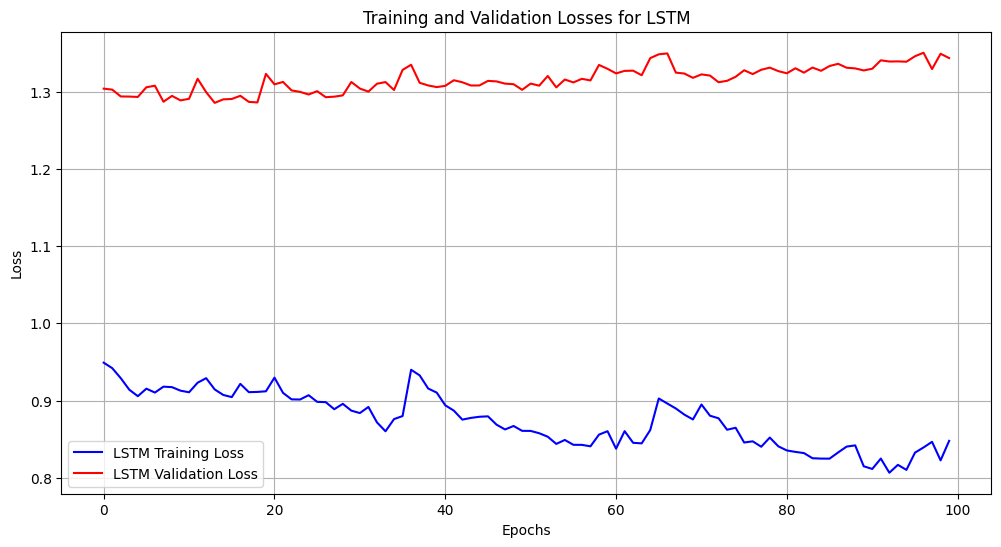

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(train_losses_lstm, label='LSTM Training Loss', color='blue')
plt.plot(val_losses_lstm, label='LSTM Validation Loss', color='red')
plt.title('Training and Validation Losses for LSTM')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.savefig('img/train_results_compare-50epochs.png', dpi=300, bbox_inches='tight')
plt.show()

### 4.2 Chord Distribution analysis
Lets dive into our generated sequnces and look at some important things of our data.

#### 4.2.1 Chord Distribution similartity 
This function will give a similarity score (**Jensen-Shannon**) between the generated chord distribution and the reference chord distribution. A score of 1 means they are identical, and a score of 0 means they are completely different.

In [49]:
def chord_distribution_similarity(generated_chords, reference_chords, chord_mapping):
    """
    Compares the distribution of generated chords with a reference distribution using Jensen-Shannon distance.
    
    Parameters:
    - generated_chords: List of chord progressions from the model.
    - reference_chords: List of reference chord progressions.
    - chord_mapping: Dictionary mapping chord names to indices.
    
    Returns:
    - similarity_score: A value between 0 and 1 indicating the similarity 
                        between the distributions (1 means they are identical).
    """
    
    # Flatten the chord progressions into a single list
    generated_flat = [chord for progression in generated_chords for chord in progression]
    reference_flat = [chord for progression in reference_chords for chord in progression]
    
    # Get frequency distributions
    generated_freq = Counter(generated_flat)
    reference_freq = Counter(reference_flat)
    
    # Convert chord frequencies to probability vectors
    num_chords = len(chord_mapping)
    generated_probs = [generated_freq.get(chord, 0) / len(generated_flat) for chord in chord_mapping.keys()]
    reference_probs = [reference_freq.get(chord, 0) / len(reference_flat) for chord in chord_mapping.keys()]
    
    # Calculate Jensen-Shannon distance using scipy
    js_distance = jensenshannon(generated_probs, reference_probs)
    
    # Convert the distance to a similarity score
    similarity_score = 1 - js_distance
    
    return similarity_score

    
# for testing
print("Test similartity function: ", chord_distribution_similarity([["A:min", "A:min"], ["A:min", "A:min"]], [["A:min", "A:min"], ["A:min", "B:min"]], chord_to_idx))
#print("GRU Similartity to dataset: ", chord_distribution_similarity(GRU_chords_generated, all_chords, chord_to_idx))
print("LSTM Similartity to dataset: ", chord_distribution_similarity(LSTM_chords_generated, all_chords, chord_to_idx))

Test similartity function:  0.690803316726986
LSTM Similartity to dataset:  0.835486687056515


#### 4.2.2 Padding token content
The padding tokens are sometimes prediced (especially for the LSTM). lets see how many times we predict it.

In [50]:
def percentage_of_pads(data):
    """
    Calculates the percentage of "pad" tokens in the data.

    Parameters:
    - data: 2D list containing sequences of strings.

    Returns:
    - Percentage of "pad" tokens in the data.
    """
    
    total_elements = sum(len(sequence) for sequence in data)
    pad_count = sum(sequence.count("pad") for sequence in data)
    
    return (pad_count / total_elements) 


#gru_pad_percentage = percentage_of_pads(GRU_chords_generated)
lstm_pad_percentage = percentage_of_pads(LSTM_chords_generated)

#print("Padding predicted by GRU: " , gru_pad_percentage)
print("Padding predicted by LSTM: " , lstm_pad_percentage)

Padding predicted by LSTM:  0.0


#### 4.2.3 Maj/Min Percentages 
Lets compare the percentage of maj/min chords in our generated dataset with the original ones and new ones. 

In [51]:
def percentage_of_min_maj(data):
    """
    Calculates the percentage of ":min" and ":maj" tokens in the data.

    Parameters:
    - data: 2D list containing sequences of strings.

    Returns:
    - Tuple containing (Percentage of ":min" tokens, Percentage of ":maj" tokens) in the data.
    """
    # exclude pad, bos and eos tokens
    total_elements = sum(1 for sequence in data for chord in sequence if chord not in ["pad", "<BOS>", "<EOS>"])

    min_count = sum(chord.endswith(":min") for sequence in data for chord in sequence)
    maj_count = sum(chord.endswith(":maj") for sequence in data for chord in sequence)
    
    return (min_count / total_elements) * 100, (maj_count / total_elements) * 100

#gru_min_percentage, gru_maj_percentage = percentage_of_min_maj(GRU_chords_generated)
lstm_min_percentage, lstm_maj_percentage = percentage_of_min_maj(LSTM_chords_generated)
ori_min_percentage, ori_maj_percentage = percentage_of_min_maj(all_chords)


#print("GRU minor chord percentage: ",gru_min_percentage,  "| GRU major chord percentage: ", gru_maj_percentage)
print("LSTM minor chord percentage: ",lstm_min_percentage,  "| LSTM major chord percentage: ", lstm_maj_percentage)
print("original minor chord percentage: ",ori_min_percentage,  "| Original major chord percentage: ", ori_maj_percentage)

LSTM minor chord percentage:  3.362930077691454 | LSTM major chord percentage:  10.9322974472808
original minor chord percentage:  4.62853456617568 | Original major chord percentage:  9.44214907767214


### 4.3 Exporting Sequences as MIDI

In this section, we'll utilize the Python library `pretty_midi` to export our chord sequences into MIDI files. These files can be played using the Windows media player or imported into any Digital Audio Workstation (DAW) for playback and further processing.

#### 4.3.1 Output Chords only
Here, we will output the chord progression with the instrument piano.

In [53]:
def chord_to_notes(chord_name):
    """Converts a chord to a list of the notes (integers) for defining the chord as MIDI. 
    This version works for the extended vocabulary including major, minor, 7th, major 7th, and minor 7th chords."""
    
    note_name_to_num = {
        'C': 60, 'C#': 61, 'D': 62, 'D#': 63, 'E': 64, 'F': 65, 
        'F#': 66, 'G': 67, 'G#': 68, 'A': 69, 'A#': 70, 'B': 71,
        'E-': 63, 'A-': 68, 'B-': 70, 'D-': 61, 'G-': 66  # Adding the flat notes
    }
    
    # Extract the root note and the type (major/minor/7th/maj7/min7) from the chord name
    # maj chords have no maj at the and, e.g. F -> F:maj
    root, chord_type = chord_name.split(':')
    
    # Calculate the MIDI numbers for the root, third, fifth, and possibly seventh notes
    root_num = note_name_to_num[root]
    if "min" in chord_type:
        third_num = root_num + 3
    else:
        third_num = root_num + 4
    fifth_num = root_num + 7
    
    # Depending on the chord type, add the seventh note
    if "7" in chord_type and "maj7" not in chord_type:
        seventh_num = root_num + 10  # Dominant seventh
    elif "maj7" in chord_type:
        seventh_num = root_num + 11  # Major seventh
    else:
        seventh_num = None
    
    notes = [root_num, third_num, fifth_num]
    if seventh_num:
        notes.append(seventh_num)
    
    return notes


def progression_to_midi(chord_progression, filename='output.mid'):
    """Creates a midi file and saves it."""
    # Create a new PrettyMIDI object
    midi_data = pretty_midi.PrettyMIDI(initial_tempo=80)
    
    # Create an instrument instance for a piano (instrument number 0)
    piano_program = pretty_midi.instrument_name_to_program('Acoustic Grand Piano')
    piano = pretty_midi.Instrument(program=piano_program)
    
    # Dictionary to map rhythm prefixes to their duration
    rhythm_to_duration = {
        '1': 4,
        '2.': 3,
        '2': 2,
        '4': 1
    }
    
    current_time = 0  # Keeps track of the current end time for each chord
    
    # Iterate over the chord progression and add each chord to the MIDI file
    for chord in chord_progression:
        if chord not in ['<BOS>', '<EOS>', 'pad']:  # Ignore these tokens
            
            # Extract rhythm and chord name
            if chord[1] == '.':
                rhythm = chord[:2]
            else: 
                rhythm = chord[0]
            chord_name = chord[len(rhythm):]  # The rest of the string after removing the rhythm
            
            # Calculate start and end times based on rhythm
            start_time = current_time
            end_time = start_time + rhythm_to_duration[rhythm]
            
            # Convert chord name to MIDI notes
            notes = chord_to_notes(chord_name)
            
            # Add each note in the chord to the MIDI file
            for note_num in notes:
                note = pretty_midi.Note(velocity=100, pitch=note_num, start=start_time, end=end_time)
                piano.notes.append(note)
            
            # Update the current time to the end time of this chord
            current_time = end_time
    
    # Add the piano instrument to the PrettyMIDI object
    midi_data.instruments.append(piano)
    
    # Write out the MIDI data to a file
    midi_data.write(filename)


# Test the function
chord_progression = merge_chords(LSTM_chords_generated[0])
print(chord_progression)
progression_to_midi(chord_progression, "test2.mid")

['1E-:maj', '1E-:maj7', '1A:min7', '1D:7', '2G:maj', '4B:dim7', '4G:dim7', '2E:min7', '2A:7', '2A:min7', '2D:7', '1G:7', '1B:7', '2E:min7', '2A:7', '1B:7', '1F:min7', '1B-:7', '1E-:maj7', '1G:7', '2C:maj7', '2G:min7', '2G:maj', '2G:7', '2C:min7', '2F:7', '2B-:maj7', '4B-:dim7', '4D-:dim7', '2F:maj', '2B-:maj7', '1B-:7', '2E-:maj7', '2C:min7', '1C:7', '1C:min7', '1F:7', '1B-:7', '1A:7', '2D:7', '2A:min7', '2B:hdim7', '2E:7', '2A:hdim7', '2D:7', '2.G:maj']


In [21]:
def save_random_progression_to_midi(chord_progressions, filename_prefix="midi/piano/", model="gru"):
    # Pick a random progression from the list
    random_progression = random.choice(chord_progressions)
    
    # Get the ID (index) of the progression
    progression_id = chord_progressions.index(random_progression)
    
    # Create filename
    filename = filename_prefix + model + "-" + str(progression_id) + ".mid"
    
    # Save the progression to MIDI
    progression_to_midi(random_progression, filename)
    
    return filename

In [22]:
save_random_progression_to_midi(GRU_chords_generated, model="gru")
save_random_progression_to_midi(LSTM_chords_generated, model="lstm")

NameError: name 'GRU_chords_generated' is not defined

#### 4.3.2 JazzArrangement
Now the same, but a Jazz since we have a Jazz dataset (*・‿・)ノ⌒*:･ﾟ✧ 

**Jazz Instruments:**

- For the bass, we use the Acoustic Bass instrument.
- For the chord instrument, we use the `Electric Piano 1` instrument to give it a Rhodes-like sound.
- Keep the piano for the arpeggio but will adjust the velocity to give it a softer touch.

**Jazz Drum Pattern:**

- Make the drum pattern swing a bit to give it a jazz feel.
- Use the Ride Cymbal 1 for the on-beats and the Side Stick for the off-beats to create a simple jazz rhythm.

In [54]:
def enhanced_progression_to_midi_jazz(chord_progression, filename='output.mid', bpm=120):
    midi_data = pretty_midi.PrettyMIDI(initial_tempo=bpm)

    # Jazz Instruments
    piano_program = pretty_midi.instrument_name_to_program('Acoustic Grand Piano')
    bass_program = pretty_midi.instrument_name_to_program('Acoustic Bass')
    chord_program = pretty_midi.instrument_name_to_program('Electric Piano 1')
    
    piano = pretty_midi.Instrument(program=piano_program)
    bass = pretty_midi.Instrument(program=bass_program)
    chords = pretty_midi.Instrument(program=chord_program)
    drums = pretty_midi.Instrument(program=0, is_drum=True)
    
    # Jazz Drum patterns
    RIDE_CYMBAL = 51  # MIDI number for Ride Cymbal 1
    SIDE_STICK = 37   # MIDI number for Side Stick
    
    # Mapping of duration prefixes to their respective durations
    rhythm_to_duration = {'1': 4, '2.': 3, '2': 2, '4': 1}
    
    # Time tracker
    current_time = 0

    # Iterate over the chord progression
    for chord in chord_progression:
        if chord not in ['<BOS>', '<EOS>', 'pad']:  # Ignore these tokens
            
            # Extract rhythm and chord name
            if chord[1] == '.':
                rhythm = chord[:2]
            else: 
                rhythm = chord[0]
            chord_name = chord[len(rhythm):]  # The rest of the string after removing the rhythm
            duration = rhythm_to_duration[rhythm]

            start_time = current_time
            end_time = start_time + duration
            
            # Chord notes
            notes = chord_to_notes(chord_name)
            
            # Bass note (root of the chord)
            bass_note = pretty_midi.Note(velocity=127, pitch=notes[0]-12, start=start_time, end=end_time)
            bass.notes.append(bass_note)
            
            # Chord
            for note_num in notes:
                chord_note = pretty_midi.Note(velocity=70, pitch=note_num, start=start_time, end=end_time)
                chords.notes.append(chord_note)
            
            # Piano Arpeggio (adjusted to 1/2 note)
            arpeggio_duration = 0.5
            arpeggio_start = start_time
            while arpeggio_start < end_time:
                for j, note_num in enumerate(notes):
                    if arpeggio_start + j*arpeggio_duration >= end_time:
                        break  # Stop if we exceed the chord's end time
                    arpeggio_note = pretty_midi.Note(velocity=60, pitch=note_num, 
                                                     start=arpeggio_start + j*arpeggio_duration, 
                                                     end=arpeggio_start + (j+1)*arpeggio_duration)
                    piano.notes.append(arpeggio_note)
                arpeggio_start += len(notes) * arpeggio_duration
            
            # Jazz Drums pattern (only every 1/2 measure)
            drum_ride_intervals = [0, 0.5]
            drum_ride_start = start_time
            while drum_ride_start < end_time:
                for interval in drum_ride_intervals:
                    if drum_ride_start + interval >= end_time:
                        break  # Stop if we exceed the chord's end time
                    drum_ride = pretty_midi.Note(velocity=80, pitch=RIDE_CYMBAL, start=drum_ride_start + interval, end=drum_ride_start + interval + 0.1)
                    drums.notes.append(drum_ride)
                drum_ride_start += 1  # Increment by a whole measure for the next cycle

            # Update the current time
            current_time = end_time
    
    # Add the instruments to the PrettyMIDI object
    midi_data.instruments.extend([piano, bass, chords, drums])
    
    # Write out the MIDI data to a file
    midi_data.write(filename)



# For testing purposes
enhanced_progression_to_midi_jazz(chord_progression, "test_enhancedJAZZ2.mid")

#### WITH SAXOPHOOONE

In [55]:
def enhanced_progression_to_midi_jazz(chord_progression, filename='output.mid', bpm=120):
    """LETSSS GOOOOO. i should probably go to sleep."""
    midi_data = pretty_midi.PrettyMIDI(initial_tempo=bpm)
    piano_program = pretty_midi.instrument_name_to_program('Acoustic Grand Piano')
    bass_program = pretty_midi.instrument_name_to_program('Acoustic Bass')
    chord_program = pretty_midi.instrument_name_to_program('Electric Piano 1')
    
    piano = pretty_midi.Instrument(program=piano_program)
    bass = pretty_midi.Instrument(program=bass_program)
    chords = pretty_midi.Instrument(program=chord_program)
    drums = pretty_midi.Instrument(program=0, is_drum=True)
    
    RIDE_CYMBAL = 51
    SIDE_STICK = 37
    rhythm_to_duration = {'1': 4, '2.': 3, '2': 2, '4': 1}
    current_time = 0

    sax_program = pretty_midi.instrument_name_to_program('Alto Sax')
    sax = pretty_midi.Instrument(program=sax_program)
    major_scale_intervals = [2, 2, 1, 2, 2]
    minor_scale_intervals = [2, 1, 2, 2, 2]

    for chord in chord_progression:
        if chord not in ['<BOS>', '<EOS>', 'pad']:
            if chord[1] == '.':
                rhythm = chord[:2]
            else: 
                rhythm = chord[0]
            chord_name = chord[len(rhythm):]
            duration = rhythm_to_duration[rhythm]
            start_time = current_time
            end_time = start_time + duration
            
            notes = chord_to_notes(chord_name)
            bass_note = pretty_midi.Note(velocity=127, pitch=notes[0]-12, start=start_time, end=end_time)
            bass.notes.append(bass_note)
            
            for note_num in notes:
                chord_note = pretty_midi.Note(velocity=70, pitch=note_num, start=start_time, end=end_time)
                chords.notes.append(chord_note)
            
            arpeggio_duration = 0.5
            arpeggio_times = int(duration/arpeggio_duration)
            for j in range(arpeggio_times):
                for k, note_num in enumerate(notes):
                    arpeggio_note = pretty_midi.Note(velocity=60, pitch=note_num, start=start_time + j*len(notes)*arpeggio_duration + k*arpeggio_duration, end=start_time + j*len(notes)*arpeggio_duration + (k+1)*arpeggio_duration)
                    piano.notes.append(arpeggio_note)
            
            for j in range(int(duration)):
                drum_ride = pretty_midi.Note(velocity=80, pitch=RIDE_CYMBAL, start=start_time + j, end=start_time + j + 0.1)
                drum_side_stick = pretty_midi.Note(velocity=70, pitch=SIDE_STICK, start=start_time + j + 0.5, end=start_time + j + 0.55)
                drums.notes.append(drum_ride)
                if j % 3 == 0:
                    drums.notes.append(drum_side_stick)

            root_note = chord_to_notes(chord_name)[0]
            if "min" in chord_name:
                scale = [root_note]
                for interval in minor_scale_intervals:
                    root_note += interval
                    scale.append(root_note)
            else:
                scale = [root_note]
                for interval in major_scale_intervals:
                    root_note += interval
                    scale.append(root_note)
        
            sax_melody = generate_sax_melody(scale, start_time, end_time)
            for note, start, end in sax_melody:
                sax_note = pretty_midi.Note(velocity=90, pitch=note, start=start, end=end)
                sax.notes.append(sax_note)
        
            current_time = end_time
    
    midi_data.instruments.extend([piano, bass, chords, drums, sax])
    midi_data.write(filename)

def generate_sax_melody(scale, start_time, end_time):
    """This is purley experimental since im very much hyped by the results and cant belive how well they sound. """
    # Different note durations for the melody and their probabilities
    durations = [0.25, 0.5, 0.75, 1]  # Quarter note, half note, dotted half note, whole note
    duration_probs = [0.1, 0.5, 0.2, 0.2]  # Probabilities for each duration
    
    # Start generating the melody
    melody = []
    current_time = start_time
    while current_time < end_time:
        # Randomly choose a note duration
        duration = random.choices(durations, duration_probs)[0]
        
        # Randomly choose whether to play a note or have a rest (break)
        play_note = random.choice([True, True, True, False])
        
        if play_note:
            # Randomly choose a note from the scale
            note = random.choice(scale)
            melody.append((note, current_time, current_time + duration))
        
        # Move to the next time slot
        current_time += duration
        
    return melody

enhanced_progression_to_midi_jazz(chord_progression, "test_enhancedJAZZ-sax2.mid")

### 4.6 Discussion

#### 4.6.1 Metrics

We observe that, using the same hyper-parameters, both networks perform similarly in terms of convergence and convergence speed. The outputs from both are also quite alike. When compared to the original data, it's evident that both networks produce outputs that are very close, especially in terms of the Jensen-Shannon Divergence. The contents of Minor and Major are also strikingly similar. With the newly implemented pack_padded_sequence from PyTorch, we've completely eliminated the problem of predicting padding. Our predictions now contain 0% padding tokens. Additionally, when setting the sequence length generation limit exceptionally high, the network consistently stops predicting, as it predicts the EOS token, which is desired. The outputs from both networks now seem very reasonable. Training and computation times don't vary significantly; especially on CUDA, we experience fast training times. It's worth noting that this is partly because we set the n_layers parameter relatively low and opted for modest hidden and embedding dimensions. Through testing, these configurations were found to give the best results. Larger dimensions tend to lead to overfitting, and the network struggles to learn the chord progressions, which are relatively straightforward given our small vocabulary size.
#### 4.6.2 Personal

Listening to the generated audio files, it's clear that both networks produce harmonious chord progressions. They don't sound arbitrary, and at times, they offer cool progressions that are quite popular and recognizable. Without time information, the output feels a bit monotonous, with each bar representing a single chord. Addressing this will be the next milestone in the BA thesis!

